### **Script is allow us to test input MRI images/dicom**
##### **Prepared by --> Arka Bhowmik**
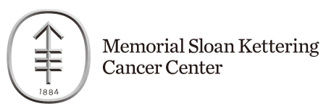

[![Python](https://img.shields.io/pypi/pyversions/tensorflow.svg?style=plastic)](https://badge.fury.io/py/tensorflow)

In [ ]:
#----------------------------------------------------------------------------------
# THIS PROGRAM TAKES A TEST CSV FILE WITH ABSOLUTE NIFTI IMAGE PATH AND PASS
# THROUGH TRAINED MODELS TO GENERATE A PROBABILITY OUTPUT FILE AND ROC PLOT
#----------------------------------------------------------------------------------
""" Note: Here, Input file is substracted T1_Fat_Sat Nifti file """
"""       a) User need to convert nifti image of T1_Fat_Sat (i.e., T1_post1-T1_pre) prior to implementing the code 
          b) The program works well for tensorflow version 2.5.3 since model uses lamda layer which is depricated 
             in recent versions of tensorflow
          c) Download the trained weight from https://drive.google.com/drive/folders/1Xdjpgld-xnEfAy1f1iTcq6BnfnibKODu?usp=sharing
             and copy weights from download folder to output folder """
#
"""IMPORT ESSENTIAL LIBRARIES"""
import os, sys, logging, time
logging.disable(logging.WARNING)  
# Hides warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow           as tf
import numpy                as np
import pandas               as pd
import nibabel              as nib
from scipy                  import stats, ndimage
from sklearn.metrics        import confusion_matrix, roc_curve
from collections            import Counter
import matplotlib.pyplot    as plt
#

In [ ]:
#
print(tf.__version__)
# 2.5.3

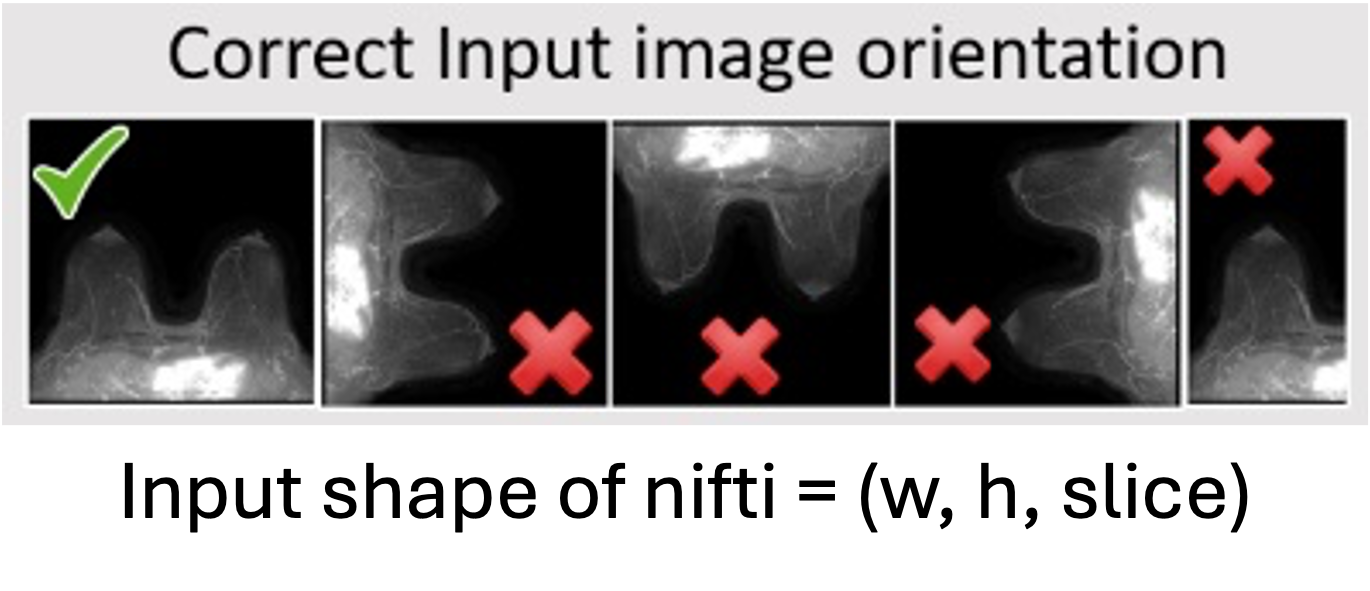

In [ ]:
#
""" Input hyperparameters """
hp = {}
hp["default_path"]   = os.path.dirname(os.path.dirname(os.path.realpath("inference.ipynb")))
hp["csv_path"]       = os.path.join(hp["default_path"], 'input')  # CSV path
hp["csv_name"]       = "test_dataset.csv"                         # CSV filename
hp["model_path"]     = os.path.join(hp["default_path"], 'output') # Model path
hp["saved_model"]    = ["unet_weight.h5", "vgg16_weight_fold1.h5", "vgg16_weight_fold2.h5", 
                        "vgg16_weight_fold3.h5", "vgg16_weight_fold4.h5", "vgg16_weight_fold5.h5"]
hp["batch_size"]     = 1
hp["test_threshold"] = 0.33                                       # Default threshold
#

In [ ]:
""" Load custom functions """
sys.path.append(hp["default_path"])
from support_function import custom_model_unet, compute_auc 
#

In [ ]:
#######
""" STEP - 1: SOME FUNCTIONS CALLED IN MAIN """
######
""" (A) CSV Reading function """
def read_csv(dirpath,filename):
    #
    """READS INTO A DATAFRAME"""
    df = pd.read_csv(os.path.join(dirpath, filename))
    img_paths = df.File_path.tolist()             # File path
    img_labels = df.Patho.tolist()                # Pathology label
    img_mrn = df.MRN.tolist()                     # MRNS
    img_acc = df.Accession.tolist()               # Accession
    #
    return img_mrn, img_acc, img_paths, img_labels
#
""" (B) Function to convert T1_FatSat_substracted NIFTI image 
    (= T1_FatSat_PostContrast 1 - T1_FatSat_PreContrast) to mip and three sub-mip """
def load_data(imgpaths_temp):
    """Load image
       :param imgpaths_temp: dummy variable for image path
       :return: mip, submip13, submip23, submip33
    """
    #
    """ Read image """
    image = nib.load(os.path.join(imgpaths_temp)).get_fdata() # shape (w, h, slice)
    #
    if (image.shape[0] == 512) and (image.shape[1] == 512):
        pass
    else:
        width_factor = 512/image.shape[0]
        height_factor = 512/image.shape[1]
        depth_factor = 1
        # RESIZE 3D IMAGE MATRIX USING SPLINE INTERPOLATION OF THE ORDER
        image = ndimage.zoom(image, (width_factor, height_factor, depth_factor), order=1)
    #
    # Extract submips from nifti data (it assumes nifti array shape (w, h, slice_num)
    length  = int(image.shape[2]/3) # Divide the slice number of 3D image by 3
    mip     = np.amax(image[:, :, 0:image.shape[2]],2)
    submip13=np.amax(image[:, :, 0:length],2)
    submip23=np.amax(image[:, :, length:(2*length)],2)
    submip33=np.amax(image[:, :, (2*length):image.shape[2]],2)
    # Rescale the image from 0 to 255 (unet has lamda layer that is rescaling inside)
    mip      = ((mip/(np.amax(mip)-np.amin(mip)))*255).clip(0,255)
    submip13 = ((submip13/(np.amax(submip13)-np.amin(submip13)))*255).clip(0,255)
    submip23 = ((submip23/(np.amax(submip23)-np.amin(submip23)))*255).clip(0,255)
    submip33 = ((submip33/(np.amax(submip33)-np.amin(submip33)))*255).clip(0,255)
    # Add an axis to sub mips
    mip      = (mip[..., tf.newaxis]).astype("float32") # (512, 512, 1)
    submip13 = (submip13[..., tf.newaxis]).astype("float32") # (512, 512, 1)
    submip23 = (submip23[..., tf.newaxis]).astype("float32") # (512, 512, 1)
    submip33 = (submip33[..., tf.newaxis]).astype("float32") # (512, 512, 1)
    #
    return mip, submip13, submip23, submip33
#
""" (C) Function to extract the images """
def process_data(x):
    #
    """This function preprocess the input data for tf.data API
        :param x: dummy variables for image path
        :return: (mip, submip13, submip23, submip33)
    """
    #
    def f(x):
        #
        path = x.decode()     # decodes the tf string to readable string
        mip, submip13, submip23, submip33 = load_data(path)
        #
        return mip, submip13, submip23, submip33
    #
    mip, submip13, submip23, submip33 = tf.numpy_function(f, [x], [tf.float32, tf.float32, tf.float32, tf.float32])
    #
    mip.set_shape([512, 512, 1])
    submip13.set_shape([512, 512, 1])
    submip23.set_shape([512, 512, 1])
    submip33.set_shape([512, 512, 1])
    #
    return ((mip, submip13, submip23, submip33), )
#
""" (D) CONVERT INTO TF DATA API PIPELINE dataset iterable
        Function to create a tf_dataset
"""
def tf_dataset(x, func_name, batch):
    #
    """This function tf_dataset
        :param x: dummy variables for path
        :param func_name: dummy variables for calling function
        :param batch: dummy variables for batch data generation
        :return: tf_dataset
    """
    #
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(func_name)
    dataset = dataset.batch(batch)
    return dataset
#
#
""" (E) Function for loading the encoders """
def load_models(dirpath, filename):
    #
    if (filename.split('_')[0]) == "unet":
        model=custom_model_unet.unet(224, 1)
        model.load_weights(os.path.join(dirpath, filename))
    else:
        model=tf.keras.models.load_model(os.path.join(dirpath, filename))
    #
    return model
#
""" (F) Function to combine Unet and VGG-16 encoders in series"""
def combined_encoder(function, dirpath, filename_1, filename_2):
    #
    input1 = tf.keras.Input((512, 512, 1)) 
    # Input shape of image (None, 512, 512, 1)
    x = tf.keras.layers.Resizing(224, 224, interpolation='bilinear')(input1) 
    # Resized the input to input shape of unet (None, 224, 224, 1)
    segmenter  = function(dirpath, filename_1)
    segmenter.trainable = False
    # load the pre-trained Vgg16 model
    classifier = function(dirpath, filename_2)
    classifier.trainable = False
    # load the pre-trained vgg16 model
    x = segmenter(x)
    # Extract the mask semented from thorax shape (none, 224, 224, 1)
    x = tf.cast(tf.math.greater_equal(x, 0.5), tf.float32)
    # Extract the binary value (0 and 1) of shape (none, 224, 224, 1)
    x = tf.keras.layers.Resizing(512, 512, interpolation='bilinear')(x)
    # Resize the binary mask value to input image shape (none, 512, 512, 1)
    x = tf.math.multiply(input1, x)
    # multiply the binary mask with input image shape (none, 512, 512, 1) segmented from thorax
    x = tf.keras.layers.Reshape([512, 512])(x)
    # reshape the array to shape (none, 512, 512)
    x_r = x[:,int(0):int(x.shape[2]), int(0):int(x.shape[1]/2)] # right breast
    x_l = x[:,int(0):int(x.shape[2]), int(x.shape[1]/2):int(x.shape[1])] # left breast
    # Divide into right and left breast each having shape (none, 512, 256) 
    x_r = tf.stack((x_r,)*3, -1)
    x_l = tf.stack((x_l,)*3, -1)
    # Stack the input channel three times each having shape (none, 512, 256, 3)
    x_r = tf.keras.layers.Resizing(256, 256, interpolation='bilinear')(x_r)
    x_l = tf.keras.layers.Resizing(256, 256, interpolation='bilinear')(x_l)
    # Resize the shape of image to input shape of vgg-16 (none, 256, 256, 3)
    x_r = tf.keras.layers.Lambda(lambda x: (x) / (tf.math.reduce_max(x)))(x_r)
    x_l = tf.keras.layers.Lambda(lambda x: (x) / (tf.math.reduce_max(x)))(x_l)
    # Normalize the images from 0 to 1
    out_r = classifier(x_r)
    out_l = classifier(x_l)
    # Vgg-16 output shape (None, 2)
    model = tf.keras.models.Model(inputs = [input1], outputs=[out_r, out_l], name = "combined_enconder")
    #
    return model
#
#
""" (G) Function to combine multiple input"""
def combined_model(function1, function2, dirpath, filename_1, filename_2):
    #
    input1 = tf.keras.Input((512, 512, 1))
    input2 = tf.keras.Input((512, 512, 1))
    input3 = tf.keras.Input((512, 512, 1))
    input4 = tf.keras.Input((512, 512, 1))
    #
    encoder = function2(function1, dirpath, filename_1, filename_2)
    out1 = encoder(input1)
    out2 = encoder(input2)
    out3 = encoder(input3)
    out4 = encoder(input4)
    #
    model = tf.keras.models.Model(inputs = [input1, input2, input3, input4], outputs=[out1, out2, out3, out4], name = "Ensemble_model")
    #
    return model
#

In [ ]:
#
global_start = time.time()    # Records the begining of the program
#
#######
""" STEP - 2: PREDICTION """
######
#
if __name__ == "__main__":
    #
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)
    #
    """ Checks availability of gpu """
    gpu_available = tf.config.list_physical_devices('GPU')
    if gpu_available:
        """ Set gpu device """
        gpus = tf.config.experimental.list_physical_devices('GPU')
        tf.config.set_visible_devices(gpus[0], 'GPU')
    #
    """ load combined models (unet + fold1-5) """
    model_fold1 = combined_model(load_models, combined_encoder, hp["model_path"], hp["saved_model"][0], hp["saved_model"][1])
    model_fold2 = combined_model(load_models, combined_encoder, hp["model_path"], hp["saved_model"][0], hp["saved_model"][2])
    model_fold3 = combined_model(load_models, combined_encoder, hp["model_path"], hp["saved_model"][0], hp["saved_model"][3])
    model_fold4 = combined_model(load_models, combined_encoder, hp["model_path"], hp["saved_model"][0], hp["saved_model"][4])
    model_fold5 = combined_model(load_models, combined_encoder, hp["model_path"], hp["saved_model"][0], hp["saved_model"][5])
    #
    """ load the CSV data with image path """
    img_mrns, img_accs, img_paths, img_labels = read_csv(hp["csv_path"],hp["csv_name"])
    """ loading tf.dataset data structure """
    ds_test= tf_dataset(img_paths, process_data, hp["batch_size"])
    #
    """ Prediction for each accession """
    pred_fold1 = model_fold1.predict(ds_test, verbose = 1) # fold1
    pred_fold2 = model_fold2.predict(ds_test, verbose = 1) # fold2
    pred_fold3 = model_fold3.predict(ds_test, verbose = 1) # fold3
    pred_fold4 = model_fold4.predict(ds_test, verbose = 1) # fold4
    pred_fold5 = model_fold5.predict(ds_test, verbose = 1) # fold5
    #
    """ INTERPRETATION OF TUPLE pred_fold1 - pred_fold5 variables
        prediction output tuple shape (4, 2, 4, 2) such that (1st, 2nd, 3rd, 4th) refers to
        1st position -> type of img 0-3, i.e., mip, submip13...submip33
        2nd position -> img laterality 0-1, i.e., 0 being right and 1 being left
        3rd position -> total number of exams in excel or csv
        4th position -> probability score 0-1, i.e., position 0 being negative probability and position 1 being positive probability
    """
    data=[]
    #
    for idx in range(len(img_paths)):
        #
        """ average of score for mip images """
        prediction_right_neg=(pred_fold1[0][0][idx][0]+pred_fold2[0][0][idx][0]+pred_fold3[0][0][idx][0]+pred_fold4[0][0][idx][0]+pred_fold5[0][0][idx][0])/5
        prediction_right_pos=(pred_fold1[0][0][idx][1]+pred_fold2[0][0][idx][1]+pred_fold3[0][0][idx][1]+pred_fold4[0][0][idx][1]+pred_fold5[0][0][idx][1])/5
        prediction_left_neg=(pred_fold1[0][1][idx][0]+pred_fold2[0][1][idx][0]+pred_fold3[0][1][idx][0]+pred_fold4[0][1][idx][0]+pred_fold5[0][1][idx][0])/5
        prediction_left_pos=(pred_fold1[0][1][idx][1]+pred_fold2[0][1][idx][1]+pred_fold3[0][1][idx][1]+pred_fold4[0][1][idx][1]+pred_fold5[0][1][idx][1])/5
        #
        """ average of score for submip 13 """
        prediction_right_1of3_neg=(pred_fold1[1][0][idx][0]+pred_fold2[1][0][idx][0]+pred_fold3[1][0][idx][0]+pred_fold4[1][0][idx][0]+pred_fold5[1][0][idx][0])/5
        prediction_right_1of3_pos=(pred_fold1[1][0][idx][1]+pred_fold2[1][0][idx][1]+pred_fold3[1][0][idx][1]+pred_fold4[1][0][idx][1]+pred_fold5[1][0][idx][1])/5
        prediction_left_1of3_neg=(pred_fold1[1][1][idx][0]+pred_fold2[1][1][idx][0]+pred_fold3[1][1][idx][0]+pred_fold4[1][1][idx][0]+pred_fold5[1][1][idx][0])/5
        prediction_left_1of3_pos=(pred_fold1[1][1][idx][1]+pred_fold2[1][1][idx][1]+pred_fold3[1][1][idx][1]+pred_fold4[1][1][idx][1]+pred_fold5[1][1][idx][1])/5
        #
        """ average of score for submip 23 """
        prediction_right_2of3_neg=(pred_fold1[2][0][idx][0]+pred_fold2[2][0][idx][0]+pred_fold3[2][0][idx][0]+pred_fold4[2][0][idx][0]+pred_fold5[2][0][idx][0])/5
        prediction_right_2of3_pos=(pred_fold1[2][0][idx][1]+pred_fold2[2][0][idx][1]+pred_fold3[2][0][idx][1]+pred_fold4[2][0][idx][1]+pred_fold5[2][0][idx][1])/5
        prediction_left_2of3_neg=(pred_fold1[2][1][idx][0]+pred_fold2[2][1][idx][0]+pred_fold3[2][1][idx][0]+pred_fold4[2][1][idx][0]+pred_fold5[2][1][idx][0])/5
        prediction_left_2of3_pos=(pred_fold1[2][1][idx][1]+pred_fold2[2][1][idx][1]+pred_fold3[2][1][idx][1]+pred_fold4[2][1][idx][1]+pred_fold5[2][1][idx][1])/5
        #
        """ average of score for submip 33 """
        prediction_right_3of3_neg=(pred_fold1[3][0][idx][0]+pred_fold2[3][0][idx][0]+pred_fold3[3][0][idx][0]+pred_fold4[3][0][idx][0]+pred_fold5[3][0][idx][0])/5
        prediction_right_3of3_pos=(pred_fold1[3][0][idx][1]+pred_fold2[3][0][idx][1]+pred_fold3[3][0][idx][1]+pred_fold4[3][0][idx][1]+pred_fold5[3][0][idx][1])/5
        prediction_left_3of3_neg=(pred_fold1[3][1][idx][0]+pred_fold2[3][1][idx][0]+pred_fold3[3][1][idx][0]+pred_fold4[3][1][idx][0]+pred_fold5[3][1][idx][0])/5
        prediction_left_3of3_pos=(pred_fold1[3][1][idx][1]+pred_fold2[3][1][idx][1]+pred_fold3[3][1][idx][1]+pred_fold4[3][1][idx][1]+pred_fold5[3][1][idx][1])/5
        #
        ensemble_probability = max(prediction_right_pos, prediction_left_pos, prediction_right_1of3_pos, 
                                   prediction_right_2of3_pos, prediction_right_3of3_pos, prediction_left_1of3_pos,
                                   prediction_left_2of3_pos, prediction_left_3of3_pos)
        """ Class prediction """
        if (prediction_right_pos<hp["test_threshold"]) and (prediction_left_pos<hp["test_threshold"]) and (prediction_right_1of3_pos<hp["test_threshold"]) and (prediction_right_2of3_pos<hp["test_threshold"]) and (prediction_right_3of3_pos<hp["test_threshold"]) and (prediction_left_1of3_pos<hp["test_threshold"]) and (prediction_left_2of3_pos<hp["test_threshold"]) and (prediction_left_3of3_pos<hp["test_threshold"]):
            pred_labels=0
        else:
            pred_labels=1
        #
        """ Store data """
        data.append((img_mrns[idx], img_accs[idx], 
                     img_paths[idx], prediction_right_pos, prediction_right_1of3_pos, prediction_right_2of3_pos, prediction_right_3of3_pos,
                     prediction_left_pos, prediction_left_1of3_pos, prediction_left_2of3_pos, prediction_left_3of3_pos, ensemble_probability,
                     img_labels[idx], pred_labels))
        #
    #
    """ header names """
    col=['MRN', 'Accession', 'File_path', 'Prob_right_mip',
         'Prob_right13_submip', 'Prob_right23_submip', 'Prob_right33_submip', 'Prob_left_mip', 
         'Prob_left13_submip', 'Prob_left23_submip', 'Prob_left33_submip','Ensemble_probability', 
         'Ground_labels', 'Predicted_labels']
    #
    output_table = pd.DataFrame(data, columns=col)
    output_table.to_csv(os.path.join(hp["model_path"], 'probability.csv'), index=False)    # SAVES THE OUTPUT TABLE
    #
#

In [ ]:
#######
""" STEP - 3: OUTPUT PERFORMANCE """
######
""" Predict sensitivity and specificity for model threshold locked at hp["test_threshold"] = 0.33 """
df = pd.read_csv(os.path.join(hp["model_path"], 'probability.csv'))
true_labels = df.Ground_labels.tolist()
pred_labels = df.Predicted_labels.tolist()
Probability = df.Ensemble_probability.tolist()
#
counter_predict  = Counter(pred_labels)
counter_ground=Counter(true_labels)
positive_labels = counter_predict[1]
negative_labels = counter_predict[0]
GTP = counter_ground[1]
GTN = counter_ground[0]
#
if (GTP!=0) and (GTN!=0):
    TN, FP, FN, TP = confusion_matrix(true_labels, pred_labels).ravel()    # DETERMINE THE CONFUSION MATRIX
    Sensitivity = TP/(TP+FN),              # RECALL OR SENSITIVITY (POSITIVE CASES CORRECTLY IDENTIFIED AS POSITIVE)
    Specificity = TN/(TN+FP),              # SPECIFICITY (NEGATIVE CASES CORRECTLY IDENTIFIED AS NEGATIVE)
    print("Performance for model threshold:", hp["test_threshold"])
    print('(a) Completely Normal exams triaged by model:', negative_labels, "\n(b) Sensitivity:", (100*Sensitivity),"%" " \n(c) Specificity:", (100*Specificity),"%")
    #
else:
    print("Performance for model threshold:", hp["test_threshold"])
    print("Completely Normal exams triaged by model:", negative_labels)
#

In [ ]:
#######
""" STEP - 4: PLOT ROC """
######
""" Predict ROC Curve for model threshold varied from 0.00 to 1.00 """
if (GTP!=0) and (GTN!=0) and (GTP>=10) and (GTN>=10):
    # Predicts the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(np.array(true_labels), np.array(Probability), pos_label=1)
    # Predicts the auc with 95% CI
    alpha = .95
    auc, auc_cov = compute_auc.delong_roc_variance(np.array(true_labels), np.array(Probability))
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    ci[ci > 1] = 1
    # Plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr,tpr,linestyle='-',color = 'black');
    plt.legend(["{} {:.3f} {} {} {:.4f}, {:.4f} {}".format('AUC:', auc, '\n95% CI:', '[', ci[0], ci[1], ']')], loc='best')
    plt.title('ROC Curve', size = 12);
    plt.xlabel('False Positive Rate', size = 12);
    plt.ylabel('True Positive Rate', size = 12);
    plt.savefig(os.path.join(hp["model_path"], 'roc.png'))
#

In [ ]:
global_end = time.time()     # End of program
#
print(f"Spent time: {round((global_end - global_start)/60, 2)} min")
#